# CUCAI Graphs

## Helper Functions

In [1]:
import torch 
import tensorflow as tf
import torch.nn as nn
import numpy as np
import gym
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
from wm_ppo import PPO

2025-03-05 11:26:05.257637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 11:26:05.840249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 11:26:07.233761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [290]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

  
    def training_step(self, batch, batch_idx):
        x, a, y = batch
        # Suppose x has shape (B, input_dim) initially
        # We want CfC to see (B, 1, input_dim)
        #x = x.unsqueeze(1)  # add time dimension => (B, 1, input_dim)
    
        # Initialize hidden state as (h, c) if mixed_memory=True
        # -> shape each = (B, hidden_size)
        h0 = torch.zeros((x.size(0), self.model.state_size), device=x.device)
        c0 = torch.zeros((x.size(0), self.model.state_size), device=x.device)
        hx = (h0, c0)
    
        # We'll do seq_len steps. a should be shape (B, seq_len, a_dim)
        seq_len = a.shape[1]
    
        predictions = []
        cur_input = x  # shape (B, 1, input_dim)
    
        for i in range(seq_len):
            # CfC sees a 3D input => is_batched=True => hx is 2D => Good
            out, hx = self.model(cur_input, hx)
            # out => (B, hidden_size) because return_sequences=False
    
            # Save the output at this timestep
            predictions.append(out.unsqueeze(1))  # => (B, 1, hidden_size)
    
            # Build next step's input = (out, a[:, i, :])
            # out is (B, hidden_size), a[:, i, :] is (B, a_dim)
            next_input = torch.cat([out, a[:, i, :]], dim=-1)  # => (B, hidden_size + a_dim)
            # CfC still wants a 3D shape => (B, 1, hidden_size+a_dim)
            cur_input = next_input.unsqueeze(1)
    
        # Stack predictions => (B, seq_len, hidden_size)
        predictions = torch.cat(predictions, dim=1)
    
        # ... compare with y of shape (B, seq_len, hidden_size) ...
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

        
            
    def validation_step(self, states, actions, new_states, batch_idx):
        
        x, a, y = batch
        #states, actions = x
        
        #rolling_inputs = torch.concatenate((states, actions[:, :states.shape[1], :]), axis=-1)
        
        predictions = []
        h = torch.zeros((x.shape[0], self.model.state_size)).to(self.model.device())
        
        for i in range(self.length):
            
            prediction, h = self.model.forward(rolling_inputs, h)
            prediction = prediction.unsqueeze(axis=1)
            predictions.append(prediction)
            prediction = torch.concatenate((prediction, a[:, i, :]), axis=-1)
            #new_sa = torch.concatenate((prediction, actions[:, states.shape[1]+i: states.shape[1]+1+1, :]), axis=-1)
            #rolling_inputs = torch.concatenate((rolling_inputs, new_sa), axis=1)
        
        
        predictions = torch.stack(predictions)
        predictions = torch.swapaxes(predictions, 0, 1)
        print(predictions.shape, " ", y.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [291]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [292]:
angular_velocity = 2
max_angular_velocity_magnitude = 8
def get_rnd_env_samples(env, num_rollouts, scale_vel = True):
    
    t_obs = []
    t_a = []
    t_n_obs = []
    for _ in range(num_rollouts):
        
        observation, info = env.reset()
        
        terminated = False
        truncated = False
    
        c_obs = []
        c_a = []
        c_n_obs = []
        
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
            obs = observation
            v_obs = torch.FloatTensor(observation)
    
            action = env.action_space.sample()
        
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            c_obs.append(obs)
            c_a.append(action)
            c_n_obs.append(observation)
       
        # Once the episode is done, close the environment
        #env.close()
    
        t_obs.append(np.vstack(c_obs))
        t_a.append(np.vstack(c_a))
        t_n_obs.append(np.vstack(c_n_obs))
    
    env.close()
    
    t_obs = np.stack(t_obs)
    t_a = np.stack(t_a)
    t_n_obs = np.stack(t_n_obs)
    
    #t_obs.shape
    #t_a.shape
    if scale_vel == True:
        t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
        t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
    
    #inputs = np.concatenate((t_obs, t_a), axis=2)

    return t_obs, t_a, t_n_obs

In [293]:
def residual_plot(outputs: np.array, residuals:np.array, title:str) -> None:
    fig,ax = plt.subplots(3,1,figsize=(14,8))
    ax[0].set_title(title)
    ax[0].scatter(outputs[:,0],residuals[:,0],label='x error',alpha=0.2)
    ax[1].scatter(outputs[:,1],residuals[:,1],label='y error',alpha=0.2)
    ax[2].scatter(outputs[:,2]*max_angular_velocity_magnitude,residuals[:,2],label='velocity error',alpha=0.2)
    for i in range(3):
      ax[i].legend()
      ax[i].grid(alpha=0.5)
      ax[i].axhline(0,ls='--',c='k')
      ax[i].set_xlabel('true value')
      ax[i].set_ylabel('prediction error')
    plt.tight_layout()

## Train Models

### NCPS

In [294]:
import gym
num_rollouts = 100 # 100 * 200 = 20,000 training samples. should be fine..? 
env = gym.make("Pendulum-v1")

In [311]:
num_rollouts = 50
s, a, n_s = get_rnd_env_samples(env, num_rollouts)
s = np.concatenate((s, a), axis=-1)
s.shape

(50, 200, 4)

In [312]:
import numpy as np

def prepare_data(s, a, n_s, traj_len):
    """
    s:      (batch_size, T, state_dim)
    a:      (batch_size, T, action_dim)
    n_s:    (batch_size, T, next_state_dim)
    traj_len: int
    
    Returns:
    --------
    data_x: shape (batch_size * (T - traj_len), 1, state_dim)
    data_a: shape (batch_size * (T - traj_len), traj_len, action_dim)
    data_y: shape (batch_size * (T - traj_len), traj_len, next_state_dim)
    """

    batch_size, T, state_dim = s.shape
    _, _, action_dim = a.shape
    _, _, next_state_dim = n_s.shape
    
    # Number of sliding windows
    num_windows = T - traj_len
    if num_windows <= 0:
        raise ValueError("traj_len must be smaller than T (the time dimension).")

    # 1) data_x corresponds to the "current state" for each window
    #    We take s[:, i, :] for i in [0 .. num_windows-1].
    #    This produces (batch, num_windows, state_dim), then we reshape.
    data_x_2d = s[:, :num_windows, :]  # shape => (batch, num_windows, state_dim)

    # 2) data_a: each window i is a[:, i : i+traj_len, :]
    #    We'll gather them in a (batch, num_windows, traj_len, action_dim) array
    data_a_4d = np.zeros((batch_size, num_windows, traj_len, action_dim), dtype=a.dtype)
    for i in range(num_windows):
        data_a_4d[:, i, :, :] = a[:, i+1 : i+traj_len+1, :]

    # 3) data_y: each window i is n_s[:, i : i+traj_len, :]
    #    We'll gather them in a (batch, num_windows, traj_len, next_state_dim) array
    data_y_4d = np.zeros((batch_size, num_windows, traj_len, next_state_dim), dtype=n_s.dtype)
    for i in range(num_windows):
        data_y_4d[:, i, :, :] = n_s[:, i : i+traj_len, :]

    # Finally, reshape by merging (batch_size * num_windows) into one dimension
    # Match your original final shapes:
    #
    #   data_x =>  (batch_size * num_windows, 1, state_dim)
    #   data_a =>  (batch_size * num_windows, traj_len, action_dim)
    #   data_y =>  (batch_size * num_windows, traj_len, next_state_dim)

    data_x = data_x_2d.reshape(batch_size * num_windows, 1, state_dim)
    data_a = data_a_4d.reshape(batch_size * num_windows, traj_len, action_dim)
    data_y = data_y_4d.reshape(batch_size * num_windows, traj_len, next_state_dim)

    return data_x, data_a, data_y

data_x, data_a, data_y = prepare_data(s, a, n_s, traj_len)

In [313]:
print(data_x[3, :, :], " WH \n", data_y[1, :, :])
print("\n")
print(data_x[1, :, :], " WH \n", data_a[1, :, :])

[[-0.95845896  0.2852305   0.13603884 -0.37893048]]  WH 
 [[-0.94152695  0.3369376   0.07737952]
 [-0.95845896  0.2852305   0.13603884]
 [-0.97435105  0.22503328  0.15567425]]


[[-0.93064886  0.36591354  0.02802909  0.80245525]]  WH 
 [[ 1.4438088 ]
 [-0.37893048]
 [ 0.7645536 ]]


In [402]:
from ncps.wirings import NCP
out_features = 3
in_features = 4

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=3, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=4, motor_fanin=2)

world_model = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True) # change to cfc, what could go wrong?

learn = MultiStepSeqLearner(world_model, lr=0.01, length=traj_len)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=20,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [403]:
s.shape

(50, 200, 4)

In [404]:
from torch.utils.data import TensorDataset, DataLoader
inputs = torch.tensor(data_x, dtype=torch.float32)
actions = torch.tensor(data_a, dtype=torch.float32)
outputs = torch.tensor(data_y, dtype=torch.float32)

# Create a single dataset that yields tuples: (inputs[i], actions[i], outputs[i])
dataset = TensorDataset(inputs, actions, outputs)

# Wrap in DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [ ]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.2 K  | train
---------------------------------------
1.1 K     Trainable params
87        Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

## Alternatively, plug and play

In [339]:
# to be implemented

## Graphs

### Random Samples

In [358]:
t_inputs, t_a, t_outputs = get_rnd_env_samples(env, 50)
t_inputs = np.concatenate((t_inputs, t_a), axis=-1)
t_inputs.shape

(50, 200, 4)

In [354]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(t_inputs[:, i:i+1, :])
    #print(c_inputs.shape)
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    #print(prediction)
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T
NCPS_ang_res = np.stack(ang_vel_residuals).T

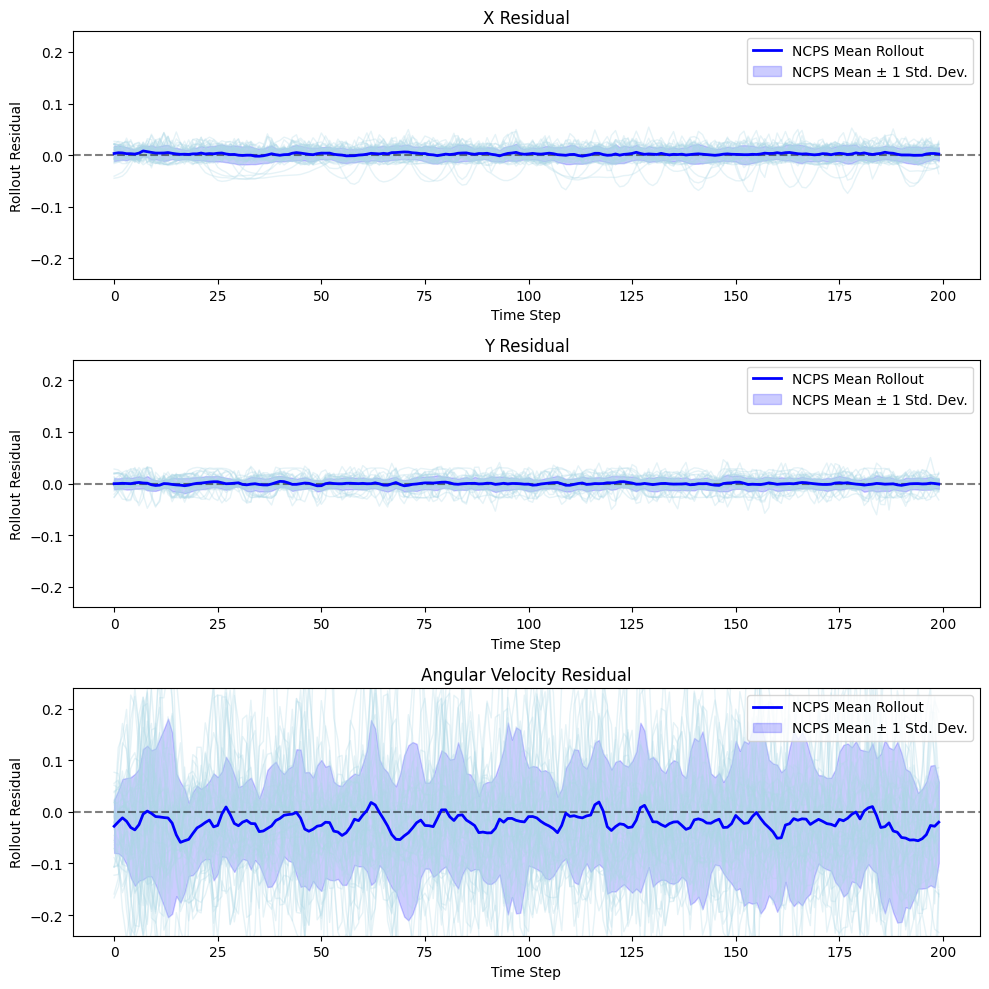

In [394]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        #ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')
    ax.set_ylim(-0.24, 0.24)

    # Compute and plot the mean
    #mean_rollout = res_2.mean(axis=0)
    #ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    #std_rollout = res_2.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
     #               color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, 0, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, 0, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_ang_res, 0, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


In [379]:
n_step_rollout = 100
cur_input = torch.FloatTensor(t_inputs[:, 0:1, :])  # shape (B, 1, input_dim)
a = torch.FloatTensor(t_a)

h0 = torch.zeros((cur_input.shape[0], world_model.state_size), device=cur_input.device)
c0 = torch.zeros((cur_input.shape[0], world_model.state_size), device=cur_input.device)
hx = (h0, c0)

# We'll do seq_len steps. a should be shape (B, seq_len, a_dim)
seq_len = a.shape[1]

predictions = []

for i in range(seq_len):
    # CfC sees a 3D input => is_batched=True => hx is 2D => Good
    with torch.no_grad():
        out, hx = world_model(cur_input, hx)
    # out => (B, hidden_size) because return_sequences=False

    # Save the output at this timestep
    predictions.append(out.unsqueeze(1))  # => (B, 1, hidden_size)

    # Build next step's input = (out, a[:, i, :])
    # out is (B, hidden_size), a[:, i, :] is (B, a_dim)
    next_input = torch.cat([out, a[:, i, :]], dim=-1)  # => (B, hidden_size + a_dim)
    # CfC still wants a 3D shape => (B, 1, hidden_size+a_dim)
    cur_input = next_input.unsqueeze(1)

# Stack predictions => (B, seq_len, hidden_size)
predictions = torch.cat(predictions, dim=1).numpy()

In [401]:
print(t_inputs[0, :10, :], "\n", t_outputs[0, :10, :])
t_inputs.shape
print(predictions[0, :10, :])

[[ 0.36774895 -0.9299251  -0.10398598  1.0409703 ]
 [ 0.3030846  -0.95296365 -0.17164826  1.2318959 ]
 [ 0.21116985 -0.97744936 -0.23789056  1.354415  ]
 [ 0.09099314 -0.9958515  -0.30413115 -1.19662   ]
 [-0.07677674 -0.9970483  -0.41992885  0.11597811]
 [-0.27764648 -0.96068335 -0.51122755  0.73819816]
 [-0.4936863  -0.86964005 -0.5874504  -1.5524011 ]
 [-0.7142544  -0.69988614 -0.6980867  -1.4312307 ]
 [-0.89648557 -0.4430729  -0.7905366   0.3728658 ]
 [-0.9916923  -0.12863271 -0.82508343 -0.21966346]] 
 [[ 0.3030846  -0.95296365 -0.17164826]
 [ 0.21116985 -0.97744936 -0.23789056]
 [ 0.09099314 -0.9958515  -0.30413115]
 [-0.07677674 -0.9970483  -0.41992885]
 [-0.27764648 -0.96068335 -0.51122755]
 [-0.4936863  -0.86964005 -0.5874504 ]
 [-0.7142544  -0.69988614 -0.6980867 ]
 [-0.89648557 -0.4430729  -0.7905366 ]
 [-0.9916923  -0.12863271 -0.82508343]
 [-0.978546    0.20602833 -0.84126145]]
[[ 0.31199214 -0.95643175 -0.18217811]
 [ 0.20643757 -0.97798187 -0.24399942]
 [ 0.09067537 -0.9

In [380]:
predictions.shape

(50, 200, 3)

[0.02290547 0.02069801 0.02826872 0.02856443 0.00392385 0.00762763
 0.02738641 0.01386275 0.01010703 0.06190924 0.02420624 0.02381282
 0.01071302 0.01103233 0.05549301 0.02211668 0.02830213 0.03415266
 0.01649674 0.03020518 0.0487842  0.05823807 0.03187998 0.05834191
 0.0259715  0.01333205 0.00868236 0.01845839 0.01547885 0.02820702
 0.00769451 0.02780522 0.04534614 0.00798712 0.01885089 0.02425971
 0.02984122 0.01292634 0.02648477 0.0123811  0.05595605 0.01681307
 0.05068137 0.03441303 0.03704203 0.02310108 0.05422299 0.04789904
 0.05548047 0.00835907]


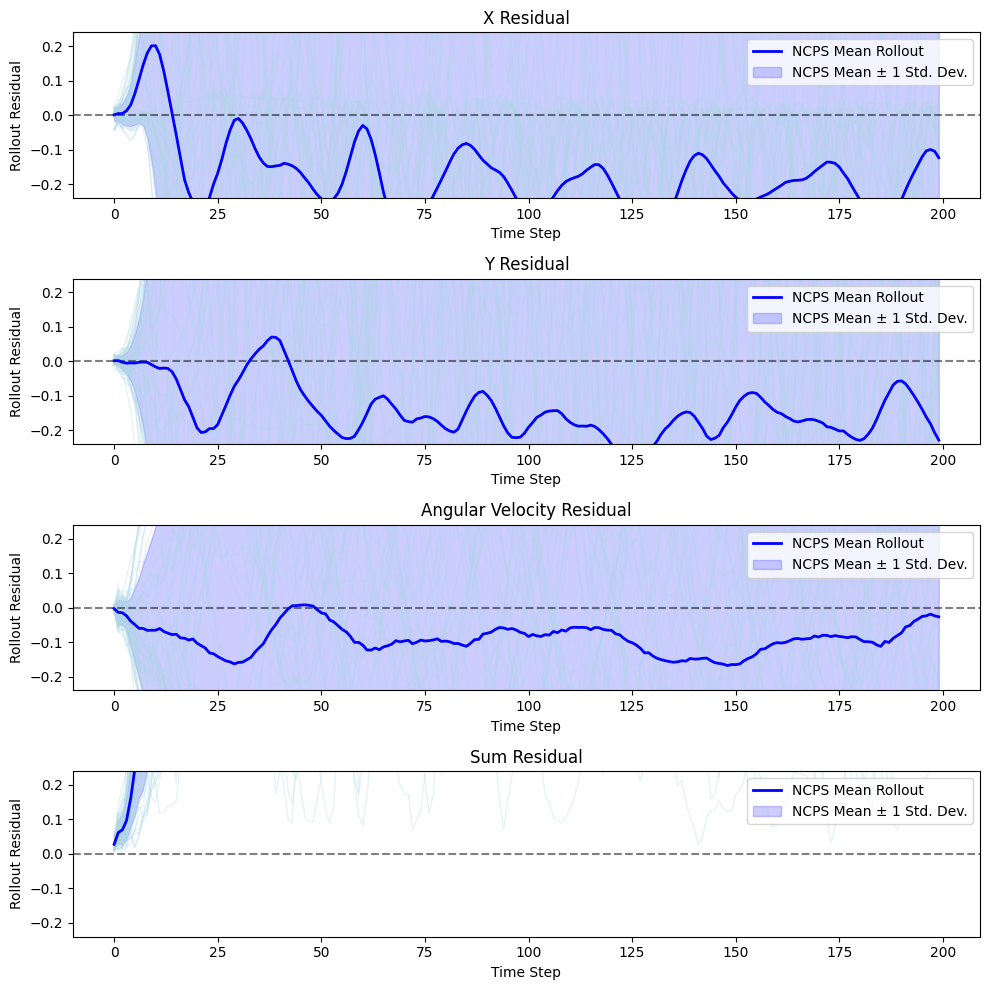

In [396]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

NCPS_res = predictions - t_outputs[:, :, :]
NCPS_total_res = np.sum(np.abs(NCPS_res), axis=-1)
#print(NCPS_res[:, :, 0].shape)
print(NCPS_total_res[:, 0])
# Plot for x_res
plot_residuals(axes[0], NCPS_res[:, :, 0], 0, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_res[:, :, 1], 0, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_res[:, :, 2], 0, "Angular Velocity Residual")
plot_residuals(axes[3], NCPS_total_res, 0, "Sum Residual")

plt.tight_layout()
plt.show()


### Save model


In [215]:
num_s = str(num_rollouts)
PATH = f"models/NCPS_N_{num_s}"
torch.save(world_model.state_dict(), PATH + '/weights')

with open(PATH + '/adj_mat.npy', 'wb') as f:
    np.save(f, wiring.adjacency_matrix)

with open(PATH + '/sens_mat.npy', 'wb') as f:
    np.save(f, wiring.sensory_adjacency_matrix )


### Load Model

In [176]:
out_features = 3
in_features = 4

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=3, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=0, motor_fanin=2)

num_s = str(num_rollouts) # This is how many rollouts we have, in this case it's 100.
PATH = f"models/NCPS_N_{num_s}"

with open(PATH + '/adj_mat.npy', 'rb') as f:
    adj = np.load(f)

with open(PATH + '/sens_mat.npy', 'rb') as f:
    sens = np.load(f)

wiring.adjacency_matrix = adj
wiring.sensory_adjacency_matrix = sens

NCPS = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True) 
NCPS.load_state_dict(torch.load(PATH+ "/weights", weights_only=True))

<All keys matched successfully>

### PPO Samples

In [71]:
t_obs = []
t_a = []
t_n_obs = []
for _ in range(50):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False

    c_obs = []
    c_a = []
    c_n_obs = []
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation
        v_obs = torch.FloatTensor(observation)

        action, log_prob = agent.get_action(v_obs)
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        c_obs.append(obs)
        c_a.append(action)
        c_n_obs.append(observation)
   
    # Once the episode is done, close the environment
    #env.close()

    t_obs.append(np.vstack(c_obs))
    t_a.append(np.vstack(c_a))
    t_n_obs.append(np.vstack(c_n_obs))

env.close()

t_obs = np.stack(t_obs)
t_a = np.stack(t_a)
t_n_obs = np.stack(t_n_obs)

t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_inputs = np.concatenate((t_obs, t_a), axis=2)

In [220]:
# NCPS Residuals

#t_inputs = t_obs
t_outputs = t_n_obs

x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T
NCPS_ang_res = np.stack(ang_vel_residuals).T

In [221]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    #c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    prediction = np.array(DNN_world_model.predict([t_inputs[:, i,:3],
                                      np.zeros((50,3)),
                                      t_inputs[:, i,3:]])).squeeze()

    # add residuals
    #prediction = t_outputs[:, i, :] + prediction
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━

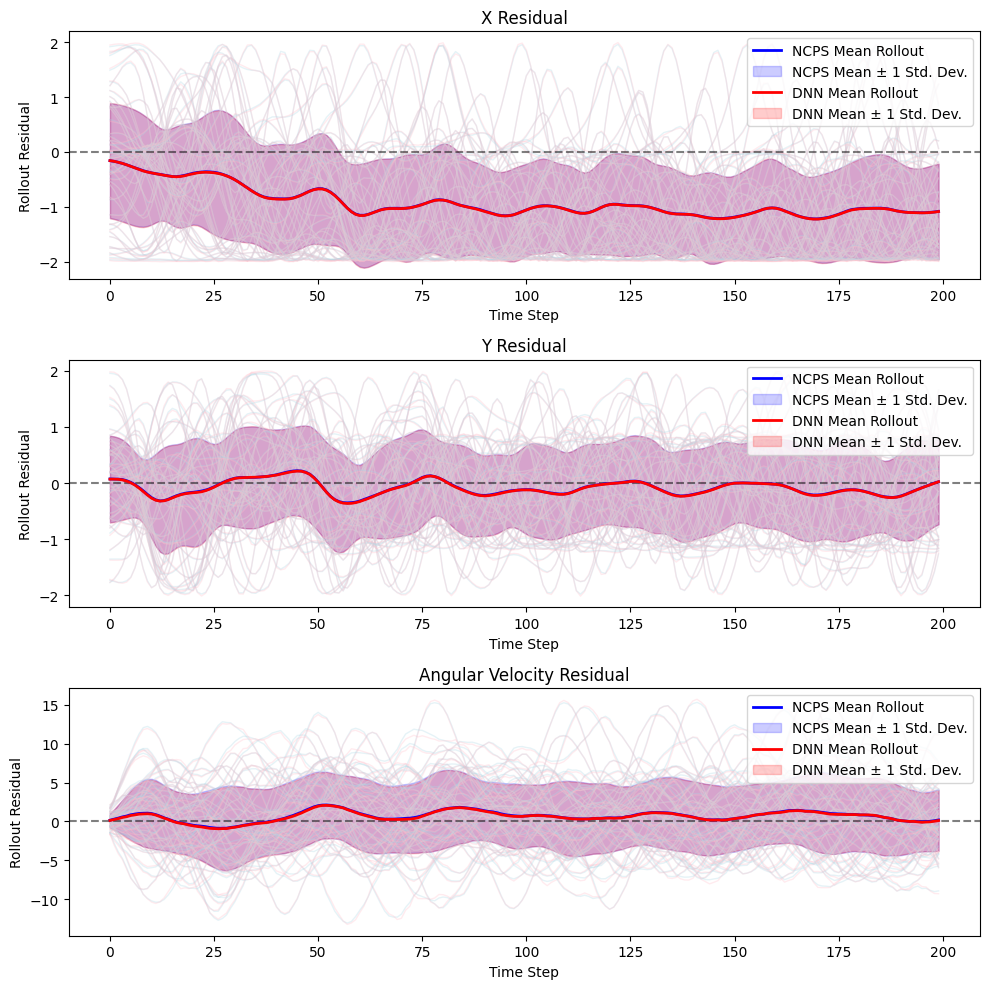

In [222]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_ang_res, DNN_ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


### 50 Samples Trajectories

In [223]:
inputs, outputs = get_rnd_env_samples(env, 50)

set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = torch.FloatTensor(time_horizon[-1])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2] - outputs[:, i, 2])

    #print(c_inputs)
    #print(prediction)

    res = prediction - outputs[:, i+1, :]

    #print("residuals: ", res)

    set_of_residuals.append(np.sum(np.abs(prediction - outputs[:, i, :]), axis=1))

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)


x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T
set_of_res = np.stack(set_of_residuals).T
ang_res.shape

(50, 150)

In [224]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []
set_of_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = time_horizon[-1]
    zeros = np.zeros((50, 3))
    #print(c_inputs.shape)
    prediction = DNN_world_model((c_inputs[:, :3],zeros, c_inputs[:, 3]))
    prediction = np.array(prediction).squeeze()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2] - outputs[:, i, 2])
    set_of_residuals.append(np.sum(np.abs(prediction - outputs[:, i, :]), axis=1))

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T
DNN_res = np.stack(set_of_residuals).T

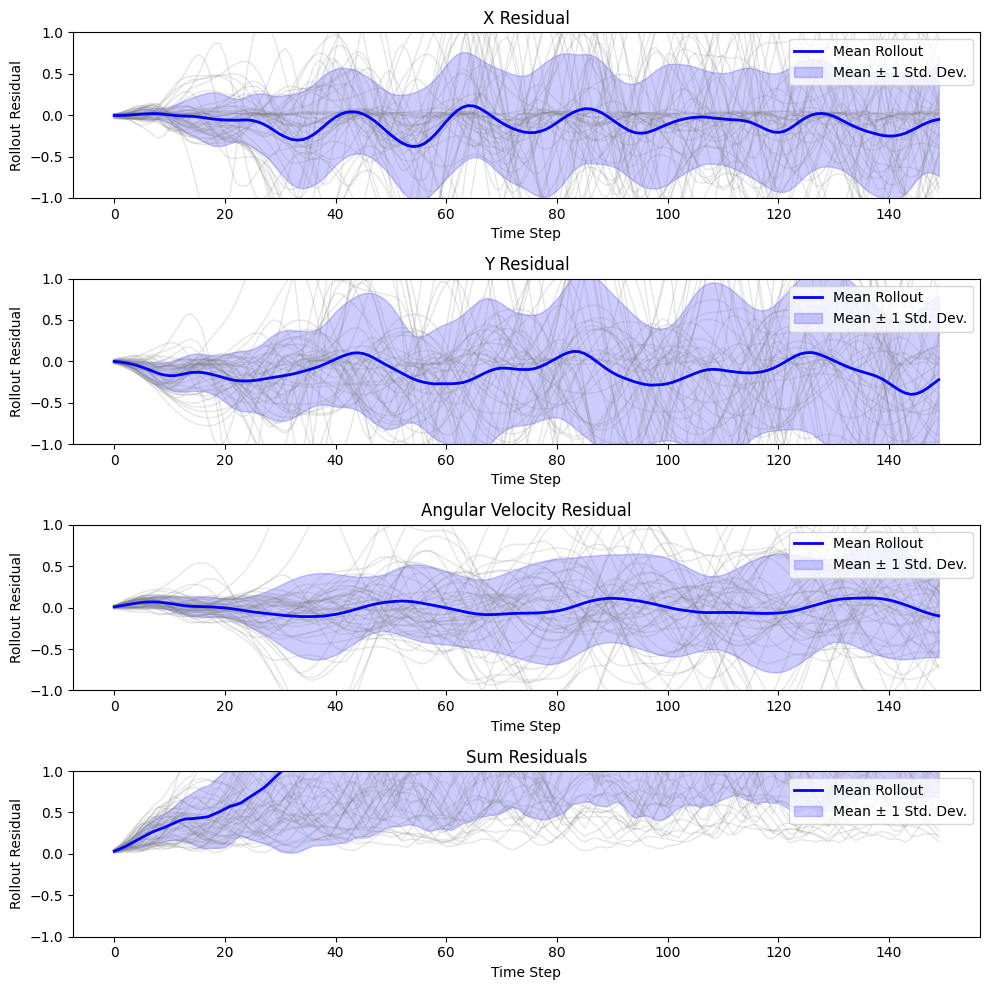

In [225]:
# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    ax.set_ylim(-1, 1)
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plot_residuals(axes[3], set_of_res, "Sum Residuals")

plt.tight_layout()
plt.show()


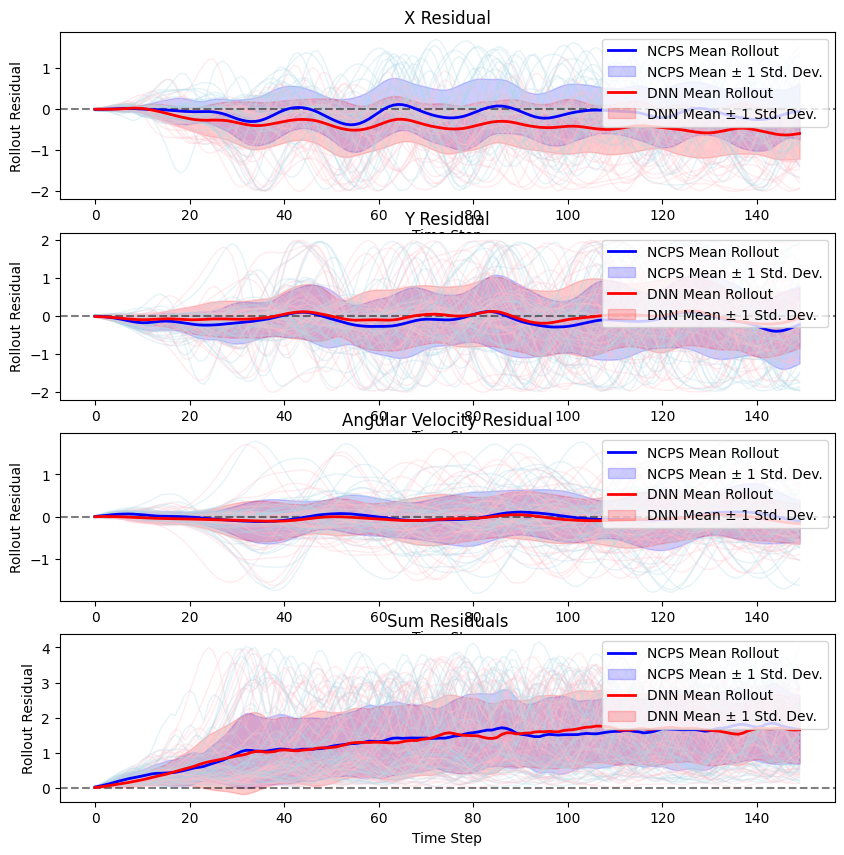

In [226]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, DNN_ang_res, "Angular Velocity Residual")

# Plot for total res
plot_residuals(axes[3], set_of_res, DNN_res, "Sum Residuals")



In [ ]:
# backburner code
x_ins = []
y_ins = []
a_ins = []
traj_len = 3
look_ahead = 0 
for i in range(num_rollouts - traj_len):
    x_ins.append(s[:, i:i+1, :])
    a_ins.append(a[:, i+1:i+traj_len, :])
    y_ins.append(n_s[:, i:i+traj_len, :])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x_ins).swapaxes(0, 1)
data_a = np.stack(a_ins).swapaxes(0, 1)
data_a = np.stack(a_ins).reshape(-1, traj_len, 1)
print(data_a.shape)
data_x = data_x.reshape(-1, 1, 4)
print(data_x.shape)
data_y = np.stack(y_ins).swapaxes(0, 1)
data_y.shape
data_y = data_y.reshape(-1, traj_len, 3)
data_y.shape